In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import os
os.environ['KERAS_BACKEND'] = "tensorflow"
import keras
import keras.backend as K
from keras import layers, Model
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# import tensorflow as tf

from modules.dataset import EquilibratedDataset
from modules.encoding import ProteinOneHotEncoder

# from modules.data.loader import SequenceEncodingDataGenerator

## Encoding

### NLF

We want to encode the sequence first, and retrieve the encoded for each sequence in the join later.

In [52]:
encoder = ProteinOneHotEncoder()

In [53]:
vector_size = 200
X, y, vector_size, alphabet_size = EquilibratedDataset(encoder).getdata(vector_size)

x_ab, x_ag = X


In [54]:
x_train_ab, x_test_ab, x_train_ag, x_test_ag, y_train, y_test = train_test_split(x_ab, x_ag, y, test_size=0.2, random_state=42, stratify=y)


In [55]:
input_dimensions = (vector_size, alphabet_size)
input_dimensions

(200, 22)

## Siamese network

In [56]:
seq_input1 = layers.Input(shape=input_dimensions, name='seq_ag')
seq_input2 = layers.Input(shape=input_dimensions, name='seq_ab')

In [57]:
# Convolutional modules
filters = 96


conv01 = layers.Conv1D(filters, 11, padding='same', activation="relu")
mp1 = layers.MaxPooling1D(3)
conv02 = layers.Conv1D(filters*2, 7, padding='same', activation="relu")
mp2 = layers.MaxPooling1D(3)
conv03 = layers.Conv1D(filters*4, 3, padding='same', activation="relu")
mp3 = layers.MaxPooling1D(3)
conv04 = layers.Conv1D(filters*2, 3, padding='same', activation="relu")
mp4 = layers.MaxPooling1D(3)

gru = layers.Bidirectional(layers.GRU(filters, return_sequences=False))

def siamese_propagation(x):
    x = conv01(x)
    x = mp1(x)

    x = conv02(x)
    x = mp2(x)

    x = conv03(x)
    x = mp3(x)

    x = conv04(x)
    x = mp4(x)

    x_gru = gru(x)
    return x_gru



In [58]:
def forward(left, right):
    left = siamese_propagation(left)
    right = siamese_propagation(right)

    merge = layers.multiply([left, right])

    # merge = layers.Dense(filters*2, activation='relu')(merge)
    merge = layers.Dropout(0.2)(merge)
    return layers.Dense(1, activation='sigmoid')(merge)

In [59]:
def f1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    pred_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (pred_pos + K.epsilon())
    recall = tp / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def accuracy(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    return (tp + tn) / (tp + tn + fp + fn)

In [60]:
def binary_crossentropy(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = - K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    return loss

In [62]:
model = Model(inputs=[seq_input1, seq_input2],
            outputs=[forward(seq_input1, seq_input2)])

adam = Adam(learning_rate=1e-4, amsgrad=True, epsilon=1e-6)

checkpoint_callback = keras.callbacks.ModelCheckpoint(f'run/models/siamese/one-hot-{vector_size}-model.h5', monitor='val_mcc', mode='max')
earlystop_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model.compile(optimizer=adam, loss=binary_crossentropy, metrics=[accuracy, f1, mcc])


history = model.fit([x_train_ab, x_train_ag], y_train, epochs=50, callbacks=[checkpoint_callback, earlystop_callback],
          batch_size=64, verbose=1, validation_split=0.15)


Epoch 1/50
241/241 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8286 - f1: 0.8161 - mcc: 0.6611

/home/sortion/micromamba/envs/intelligent-antibodies/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/241 [==============================] - 13s 29ms/step - loss: 0.3928 - accuracy: 0.8286 - f1: 0.8161 - mcc: 0.6611 - val_loss: 0.3634 - val_accuracy: 0.8384 - val_f1: 0.8490 - val_mcc: 0.6778
Epoch 2/50
241/241 [==============================] - 6s 23ms/step - loss: 0.3156 - accuracy: 0.8695 - f1: 0.8653 - mcc: 0.7408 - val_loss: 0.3429 - val_accuracy: 0.8621 - val_f1: 0.8581 - val_mcc: 0.7323
Epoch 3/50
241/241 [==============================] - 6s 25ms/step - loss: 0.2883 - accuracy: 0.8834 - f1: 0.8796 - mcc: 0.7682 - val_loss: 0.3206 - val_accuracy: 0.8614 - val_f1: 0.8686 - val_mcc: 0.7226
Epoch 4/50
241/241 [==============================] - 6s 25ms/step - loss: 0.2769 - accuracy: 0.8869 - f1: 0.8840 - mcc: 0.7754 - val_loss: 0.3317 - val_accuracy: 0.8561 - val_f1: 0.8668 - val_mcc: 0.7146
Epoch 5/50
241/241 [==============================] - 6s 26ms/step - loss: 0.2578 - accuracy: 0.8965 - f1: 0.8940 - mcc: 0.7942 - val_loss: 0.3144 - val_accuracy: 0.8720 - val_f1: 0.8716 - v

In [30]:
len(x_train_ab)

18113

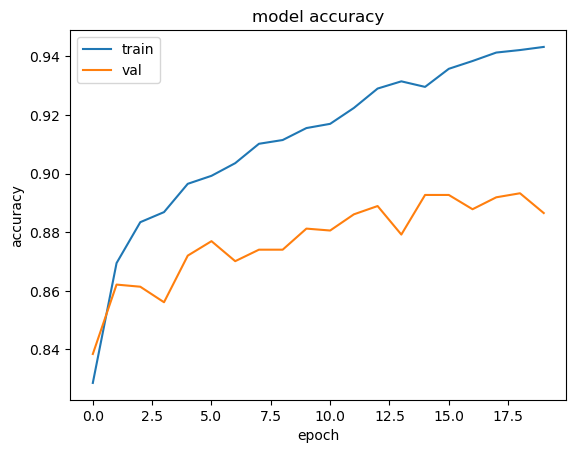

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

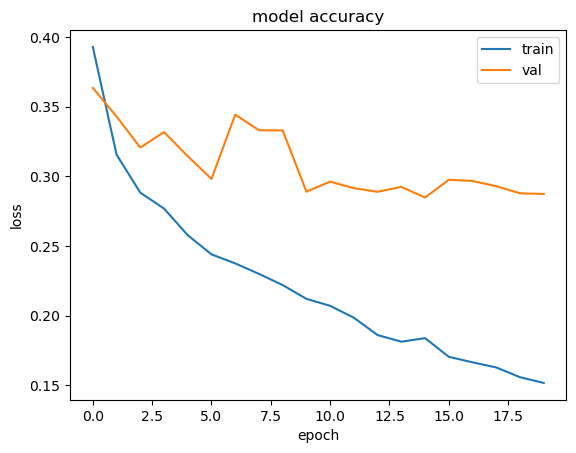

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()